## Latent Semantic Analysis and Clustering

Using the tokens generated from the abstracts and keywords of the papers, we perform Latent Semantic Analysis (LSA, aka LSI) using gensim. After projecting the papers to the LSA space, kmeans clustering was performed. The best number of clusters was selected using the silhouette score. The obtained clusters were analyzed by checking the papers belong to different clusters, in order to understand the meaning of the clusters. Finally, the current status and potential future directions of quantitative susceptibility mapping and susceptibility weighted imaging using MRI was discussed.

In [1]:
import gensim
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from time import time
import pickle
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import matplotlib
figsize(11, 9)

In [2]:
with open('data/tokens_ab_key.p', 'rb') as f:
    (texts, tokens_t, tokens_k, num_citation, year, authors, acronyms)  = pickle.load(f)

In [3]:
# append tokens from keywords to the end of the abstract tokens
for i in range(len(texts)):
    texts[i]=texts[i]+tokens_k[i]

In [4]:
print(texts[0])

['susceptibility_weighted_imaging', 'magnetic_resonance_imaging', 'technique', 'enhances', 'image_contrast', 'susceptibility', 'difference', 'tissue', 'magnitude', 'phase', 'gradient_echo', 'data', 'susceptibility_weighted_imaging', 'diamagnetic', 'substance', 'different', 'phase_shift', 'magnetic_resonance_imaging', 'data', 'susceptibility_weighted_imaging', 'image', 'minimum', 'intensity', 'projection', 'high_resolution', 'delineation', 'venous', 'architecture', 'feature', 'magnetic_resonance_imaging', 'technique', 'susceptibility_weighted_imaging', 'venous', 'abnormality', 'susceptibility_weighted_imaging', 'deoxygenated', 'blood', 'intracranial', 'mineral', 'deposition', 'reason', 'image', 'various', 'pathology', 'intracranial', 'hemorrhage', 'traumatic_brain_injury', 'stroke', 'neoplasm', 'multiple_sclerosis', 'susceptibility_weighted_imaging', 'quantitative', 'measure', 'magnetic_susceptibility', 'limitation', 'development', 'quantitative_susceptibility_mapping', 'susceptibility'

In [5]:
def checkPaper(X, tokens_t, cx,cy):
    dist = (X[:,0]-cx)**2 + (X[:,1]-cy)**2
    ind = np.argmin(dist)
    return ind, ' '.join(tokens_t[ind])

### Latent Semantic Analysis

##### TF-IDF

In [6]:
dictionary = gensim.corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

##### LSA and KMeans Clustering

In [7]:
num_topics_total = np.arange(2,6)
centers_lsi=[]
inertia_lsi=np.zeros([len(num_topics_total),len(num_topics_total)])
silhouette_score_lsi=np.zeros([len(num_topics_total),len(num_topics_total)])
#LSI
t2 = time()
for ind, num_topics in enumerate(num_topics_total):
    lsi = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics) #TF-IDF
    corpus_lsi = lsi[corpus_tfidf]
    X=np.zeros([len(texts), num_topics])
    for i in range(0, len(texts)):
        for j in corpus_lsi[i]:
            X[i,j[0]]=j[1]
    #kmeans clustering
    centers_temp=[]
    for indk, k in enumerate(num_topics_total):
        km = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=1000)
        km.fit(X)
        centers_temp.append(km.cluster_centers_)
        inertia_lsi[ind,indk] = km.inertia_
        silhouette_score_lsi[ind,indk] = metrics.silhouette_score(X, km.labels_)
    centers_lsi.append(centers_temp)
t3 = time()
print("LSI grid search done in %0.3fs" % (t3 - t2))

LSI grid search done in 54.753s


([], <a list of 0 Text yticklabel objects>)

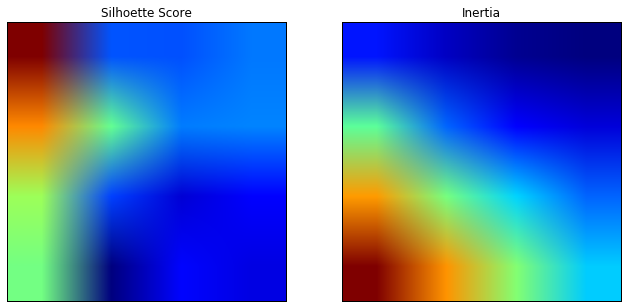

In [8]:
plt.subplot(1,2,1)
plt.imshow(silhouette_score_lsi)
plt.title('Silhoette Score')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(inertia_lsi)
plt.title('Inertia')
plt.xticks([])
plt.yticks([])

2 latent dimensions, 2 clusters.

In [9]:
silhouette_score_lsi[0,0]

0.69287529969543227

In [10]:
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2) #TF-IDF
corpus_lsi = lsi[corpus_tfidf]

In [11]:
lsi.print_topics(2)

[(0,
  '-0.261*"lesion" + -0.188*"quantitative_susceptibility_mapping" + -0.158*"phase" + -0.154*"susceptibility_weighted_imaging" + -0.142*"iron" + -0.138*"patient" + -0.111*"brain" + -0.108*"image" + -0.105*"magnetic_susceptibility" + -0.097*"susceptibility"'),
 (1,
  '-0.716*"lesion" + -0.127*"multiple_sclerosis" + -0.104*"patient" + 0.097*"artifact" + 0.092*"susceptibility_map" + 0.088*"orientation" + -0.081*"outcome" + 0.079*"magnetic_field" + 0.076*"error" + 0.075*"reconstruction"')]

### The meaning of latent dimensions
While the first dimension is determined by lesion, QSM, SWI, iron, patient etc., the second dimension is more related to technical terms such as artifact, susceptibiltiy map, orientation etc..

In [13]:
X=np.zeros([len(texts), 2])
for i in range(0, len(texts)):
    for j in corpus_lsi[i]:
        X[i,j[0]]=j[1]

In [14]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=1000)
km.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=1000, n_clusters=2,
    n_init=1000, n_jobs=1, precompute_distances='auto', random_state=None,
    tol=0.0001, verbose=0)

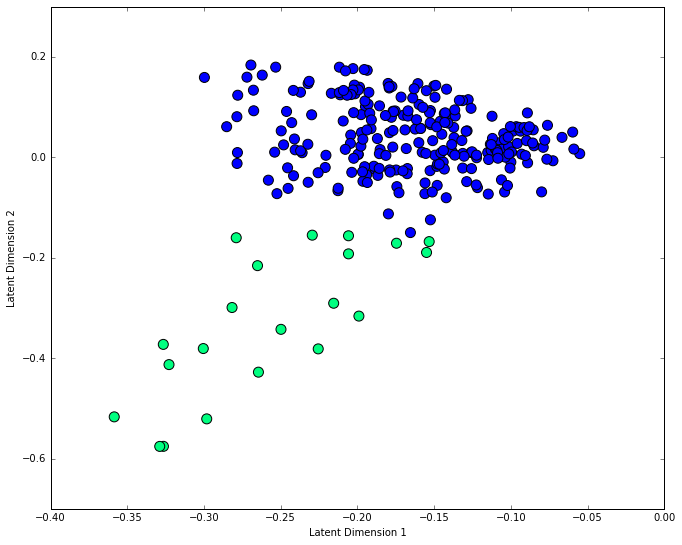

In [15]:
labels = km.labels_
colors = matplotlib.cm.winter(np.linspace(0, 1, 2))
cc = [colors[i] for i in labels]
plt.scatter(X[:, 0], X[:, 1], c=cc, s=100)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

### The meaning of clusters: multiple sclerosis lesions and iron content
By checking the papers in the green cluster, it can be seen that the papers are mostly related to multiple sclerosis and iron content. 

In [26]:
print(checkPaper(X, tokens_t, -0.28, -0.2))
print(checkPaper(X, tokens_t, -0.23, -0.2))
print(checkPaper(X, tokens_t, -0.15, -0.2))

(252, 'analysis of multiple sclerosis lesions using a fusion of 3 0 t flair and 7 0 t swi phase flair swi')
(43, 'multiple sclerosis lesion geometry in quantitative susceptibility mapping qsm and phase imaging')
(246, 'imaging of stroke a comparison between x ray fluorescence and magnetic resonance imaging methods')


In [28]:
print(checkPaper(X, tokens_t, -0.33, -0.4))
print(checkPaper(X, tokens_t, -0.3, -0.4))
print(checkPaper(X, tokens_t, -0.23, -0.4))
print(checkPaper(X, tokens_t, -0.33, -0.6))

(34, 'improved detection of cortical gray matter involvement in multiple sclerosis with quantitative susceptibility mapping')
(42, 'quantitative susceptibility mapping qsm of white matter multiple sclerosis lesions interpreting positive susceptibility and the presence of iron')
(54, 'iron and non iron related characteristics of multiple sclerosis and neuromyelitis optica lesions at 7t mri')
(157, 'magnetic susceptibility contrast variations in multiple sclerosis lesions')


### The meaning of clusters: technical papers

In [29]:
print(checkPaper(X, tokens_t, -0.3, 0.2))
print(checkPaper(X, tokens_t, -0.25, 0.2))
print(checkPaper(X, tokens_t, -0.2, 0.2))

(149, 'whole brain susceptibility mapping at high field a comparison of multiple and single orientation methods')
(105, 'reducing the object orientation dependence of susceptibility effects in gradient echo mri through quantitative susceptibility mapping')
(58, 'quantitative susceptibility mapping using structural feature based collaborative reconstruction sfcr in the human brain')


In [30]:
print(checkPaper(X, tokens_t, -0.25, 0.1))
print(checkPaper(X, tokens_t, -0.2, 0.1))
print(checkPaper(X, tokens_t, -0.15, 0.1))

(12, 'quantitative susceptibility mapping current status and future directions')
(11, 'quantitative susceptibility mapping of human brain at 3t a multisite reproducibility study')
(162, 'selective channel combination of mri signal phase')


In [32]:
print(checkPaper(X, tokens_t, -0.1, 0.0))
print(checkPaper(X, tokens_t, -0.1, 0.05))
print(checkPaper(X, tokens_t, -0.1, 0.1))

(124, 'comparison of susceptibility weighted imaging and tof angiography for the detection of thrombi in acute stroke')
(75, 'task evoked brain functional magnetic susceptibility mapping by independent component analysis chiica')
(77, 'iterative projection onto convex sets for quantitative susceptibility mapping')


### Popularity of the papers
Let's now design a feature to represent the popularity of the paper. Particularly, the popularity should be proportional to the number of citations. But this may favor older papers, but ignore the new papers which get lots of citations within a short period. Hence, we define the popuarity as num_citation/(min(num_y)-num_y+1). 

In [33]:
num_c=np.asarray(num_citation)
num_c = num_c.astype(float)
num_y=np.asarray(year)
num_y = num_y.astype(float)
popularity =  (num_c+1)/(max(num_y)-num_y+1)

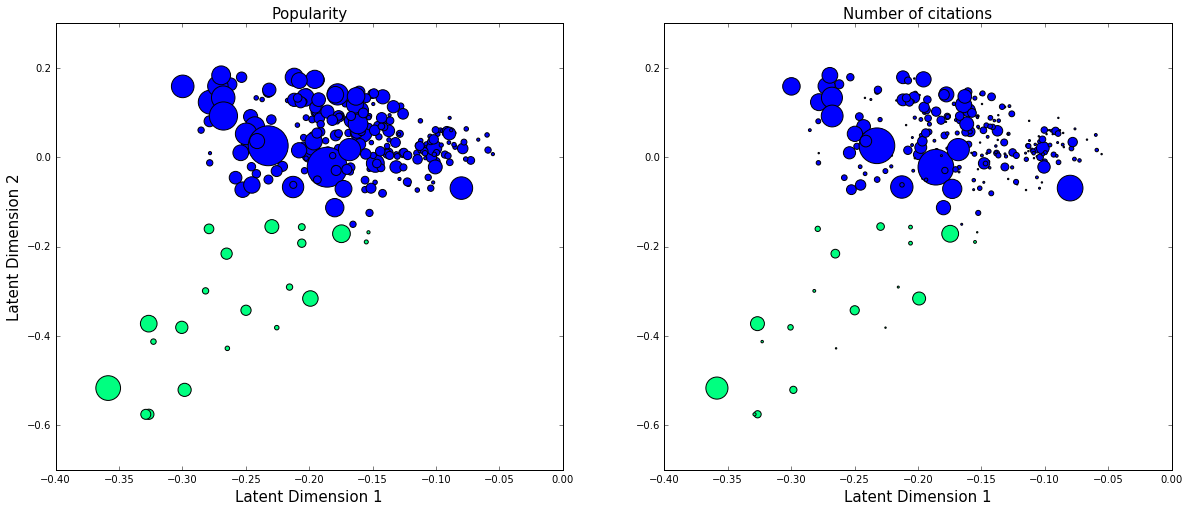

In [34]:
figsize(20,8)
plt.subplot(1,2,1)
ss = popularity * 20
plt.scatter(X[:, 0], X[:, 1], c=cc, s=ss)
plt.xlabel('Latent Dimension 1', fontsize=15)
plt.ylabel('Latent Dimension 2', fontsize=15)
plt.title('Popularity', fontsize=15)
plt.subplot(1,2,2)
ss = (num_c +1) * 2
plt.scatter(X[:, 0], X[:, 1], c=cc, s=ss)
plt.xlabel('Latent Dimension 1', fontsize=15)
plt.title('Number of citations', fontsize=15)

There are a lot of popular papers in the blue group. Note that the popularity measure captures those papers with relatively small citation number but are also relatively new. This suggests that these papers have been cited frequently recently, reflecting the trend of research in this field. 

Clearly, studies related to multiple sclerosis is becoming less popular, both in terms of absolute number of citation and the popularity measure. Now let's check the fine structures of the blue cluster by applying another kmeans clustering.

### Analyzing fine structures of the cluster

In [40]:
print('There are {} papers in the green cluster and {} papers in the blue cluster.'.format(sum(labels==1),sum(labels==0)))

There are 21 papers in the green cluster and 244 papers in the blue cluster.


In [43]:
X1=X[labels==0]

In [48]:
#kmeans clustering
silhouette_score_blue=np.zeros(len(num_topics_total))
inertia_blue=np.zeros(len(num_topics_total))
for indk, k in enumerate(num_topics_total):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=1000)
    km.fit(X1)
    inertia_blue[indk] = km.inertia_
    silhouette_score_blue[indk] = metrics.silhouette_score(X1, km.labels_)

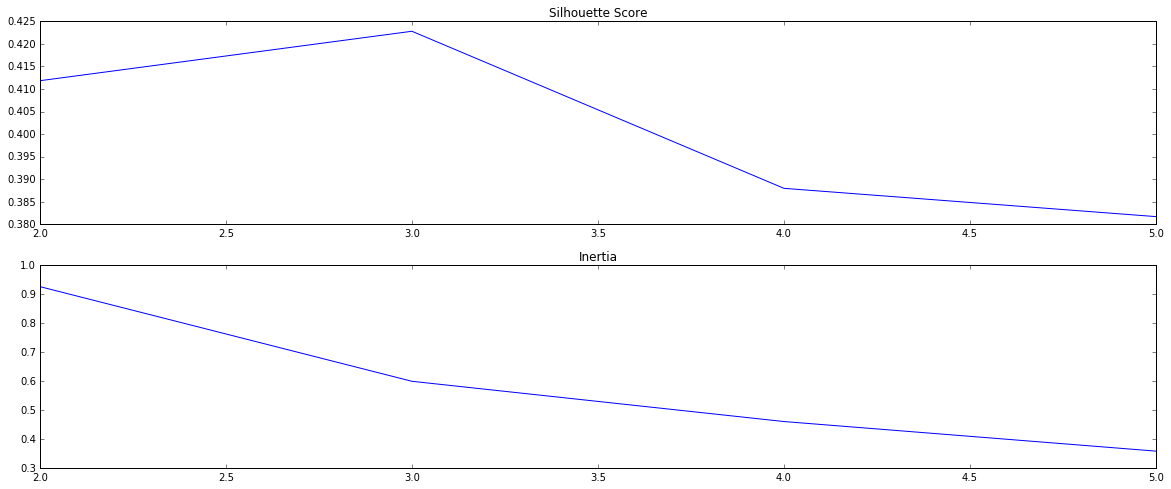

In [50]:
plt.subplot(2,1,1)
plt.plot(num_topics_total,silhouette_score_blue)
plt.title('Silhouette Score');
plt.subplot(2,1,2)
plt.plot(num_topics_total,inertia_blue)
plt.title('Inertia')

From both the Silhouette score and the inertia, the optmial number of clusters was chosen to be 3.

In [51]:
km = KMeans(n_clusters=3, init='k-means++', max_iter=1000, n_init=1000)
km.fit(X1)

KMeans(copy_x=True, init='k-means++', max_iter=1000, n_clusters=3,
    n_init=1000, n_jobs=1, precompute_distances='auto', random_state=None,
    tol=0.0001, verbose=0)

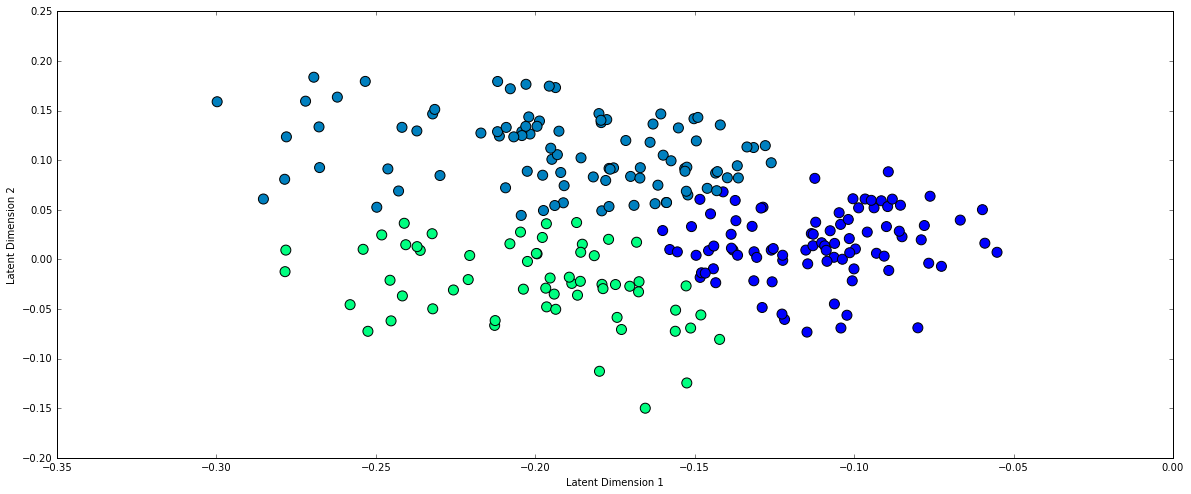

In [84]:
labels_blue = km.labels_
colors = matplotlib.cm.winter(np.linspace(0, 1, 3))
cc = [colors[i] for i in labels_blue]
plt.scatter(X1[:, 0], X1[:, 1], c=cc, s=100)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

In [85]:
num_c_b = num_c[labels==0]
num_y_b = num_y[labels==0]
popularity_b =  (num_c_b+1)/(max(num_y_b)-num_y_b+1)
cc = np.array(cc)

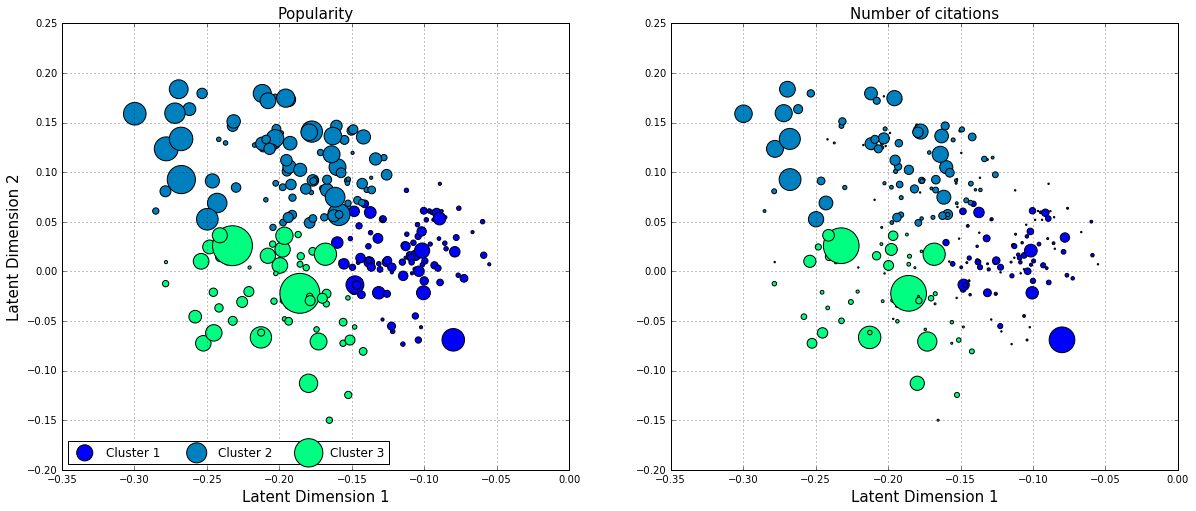

In [93]:
figsize(20,8)
plt.subplot(1,2,1)
ss = popularity_b * 20

c1 = plt.scatter(X1[labels_blue==0, 0], X1[labels_blue==0, 1], c=cc[labels_blue==0], s=ss[labels_blue==0])
c2 = plt.scatter(X1[labels_blue==1, 0], X1[labels_blue==1, 1], c=cc[labels_blue==1], s=ss[labels_blue==1])
c3 = plt.scatter(X1[labels_blue==2, 0], X1[labels_blue==2, 1], c=cc[labels_blue==2], s=ss[labels_blue==2])

plt.xlabel('Latent Dimension 1', fontsize=15)
plt.ylabel('Latent Dimension 2', fontsize=15)
plt.title('Popularity', fontsize=15)
plt.legend((c1, c2, c3), ('Cluster 1', 'Cluster 2', 'Cluster 3'), scatterpoints=1,loc='lower left',
           ncol=3,
           fontsize=12)
plt.grid()
plt.subplot(1,2,2)
ss = (num_c_b +1) * 2
c4 = plt.scatter(X1[labels_blue==0, 0], X1[labels_blue==0, 1], c=cc[labels_blue==0], s=ss[labels_blue==0])
c5 = plt.scatter(X1[labels_blue==1, 0], X1[labels_blue==1, 1], c=cc[labels_blue==1], s=ss[labels_blue==1])
c6 = plt.scatter(X1[labels_blue==2, 0], X1[labels_blue==2, 1], c=cc[labels_blue==2], s=ss[labels_blue==2])
plt.xlabel('Latent Dimension 1', fontsize=15)
plt.title('Number of citations', fontsize=15)
plt.grid()

The further clustering of the original blue cluster reveals that there are potentially 3 sub-clusters. It seems that, among these three clusters, cluster 1 is now the least popular research direction, except for the one on the lower right corner, which is a paper related to tumor.

In [59]:
print(checkPaper(X, tokens_t, -0.07, -0.06))

(192, 'glial tumor grading and outcome prediction using dynamic spin echo mr susceptibility mapping compared with conventional contrast enhanced mr confounding effect of elevated rcbv of oligodendrogliomas corrected')


Now let's check the papers in the three clusters.

#### Cluster 1: Various topics on quantifying tissue properties: oxygen saturation and iron mapping etc 

In [97]:
print(checkPaper(X, tokens_t, -0.15, 0.02))
print(checkPaper(X, tokens_t, -0.13, 0.02))
print(checkPaper(X, tokens_t, -0.08, 0.02))

(235, 'cerebral hemodynamic changes of mild traumatic brain injury at the acute stage')
(221, 'iron mapping using the temperature dependency of the magnetic susceptibility')
(71, 'quantitative mapping of cerebral metabolic rate of oxygen cmro2 using quantitative susceptibility mapping qsm')


#### Cluster 2: Technical papers on QSM

In [90]:
print(checkPaper(X, tokens_t, -0.3, 0.15))
print(checkPaper(X, tokens_t, -0.28, 0.15))
print(checkPaper(X, tokens_t, -0.2, 0.18))

(135, 'quantitative susceptibility mapping of human brain reflects spatial variation in tissue composition')
(138, 'susceptibility mapping as a means to visualize veins and quantify oxygen saturation')
(58, 'quantitative susceptibility mapping using structural feature based collaborative reconstruction sfcr in the human brain')


#### Cluster 3: Papers related to multiple sclerosis, myelin content and iron quantification

In [96]:
print(checkPaper(X, tokens_t, -0.25, -0.08))
print(checkPaper(X, tokens_t, -0.24, -0.06))
print(checkPaper(X, tokens_t, -0.18, -0.02))

(100, 'increased iron accumulation occurs in the earliest stages of demyelinating disease an ultra high field susceptibility mapping study in clinically isolated syndrome')
(114, 'quantitative susceptibility mapping in multiple sclerosis')
(204, 'accumulation of iron in the putamen predicts its shrinkage in healthy older adults a multi occasion longitudinal study')


### Conclusion

From the above analysis, it seems that QSM is still very promising field. Both technical development and the applications of QSM have great potentials. While the technical development is still popular, the application of QSM to multiple sclerosis, myelin content and lesions have also generated various papers with high popularity. On the other hand, the application of QSM to TBI and oxygen extraction fraction measurement seems to be a promising direction with great potential of having new findings, more citations and influences, if more studies were conducted.  

In [98]:
import pandas as pd

In [99]:
titles = []
for i in tokens_t:
    titles.append(' '.join(i))

In [115]:
results = pd.DataFrame(X, columns=['x1', 'x2'])
results['title'] = titles
results['year'] = num_y.astype(int)
results['citation'] = num_c
results['popularity'] = popularity
results['cluster']= labels
subcluster = np.ones(len(labels))*999
subcluster[labels==0]=labels_blue
results['sub-cluster']=subcluster.astype(int)

In [116]:
results.head(25)

,x1,x2,title,year,citation,popularity,cluster,sub-cluster
0,-0.248142,0.024658,susceptibility weighted imaging and quantitati...,2015,18.0,9.500000,0,2
1,-0.167448,-0.022479,susceptibility weighted imaging and mapping of...,2015,7.0,4.000000,0,2
2,-0.285252,0.060878,quantitative susceptibility mapping concepts a...,2015,3.0,2.000000,0,1
3,-0.188534,-0.024210,basal ganglia iron in patients with multiple s...,2016,1.0,2.000000,0,2
4,-0.180018,0.147007,rapid multi orientation quantitative susceptib...,2015,4.0,2.500000,0,1
5,-0.278222,0.009368,assessing global and regional iron content in ...,2015,0.0,0.500000,0,2
6,-0.241664,-0.036806,usefulness of quantitative susceptibility mapp...,2015,6.0,3.500000,0,2
7,-0.139748,0.082282,a fully flow compensated multiecho susceptibil...,2015,2.0,1.500000,0,1
8,-0.221019,-0.020338,quantitative susceptibility mapping of the mid...,2016,4.0,5.000000,0,2
9,-0.137066,0.039014,quantitative susceptibility mapping based micr...,2016,0.0,1.000000,0,0


In [117]:
results.to_csv('results.csv')